In [1]:
import yfinance as yf
import time

# Use Microsoft Ticker from past to present time
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [2]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054594,0.062623,0.054594,0.059946,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.059946,0.063158,0.059946,0.062087,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062087,0.063694,0.062087,0.063158,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063158,0.063694,0.061017,0.061552,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061552,0.062087,0.059946,0.060482,47894400,0.0,0.0


<Axes: xlabel='Date'>

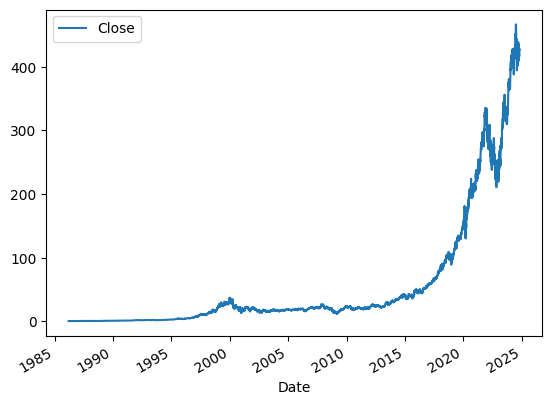

In [3]:
msft_hist.plot(y="Close", use_index=True)

In [4]:
# Roll forwawrd the close column as the actual close in the next day
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close': 'Actual Close'})
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [5]:
data["Target"].value_counts()

Target
1.0    4928
0.0    4806
Name: count, dtype: int64

In [6]:
# Shift forward dates by one day
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.054594,0.062623,0.054594,0.059946,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.059946,0.063158,0.059946,0.062087,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062087,0.063694,0.062087,0.063158,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.063158,0.063694,0.061017,0.061552,6.776640e+07,0.0,0.0


In [7]:
# Predictors and excluded the first row as it is not valid
# Actual closing price columns joined with data
# Actual closing price (actual) vs closing price at the time
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [8]:
data.head(5)

,Actual Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062087,1.0,0.059946,0.062623,0.054594,0.054594,1.031789e+09
1986-03-17 00:00:00-05:00,0.063158,1.0,0.062087,0.063158,0.059946,0.059946,3.081600e+08
1986-03-18 00:00:00-05:00,0.061552,0.0,0.063158,0.063694,0.062087,0.062087,1.331712e+08
1986-03-19 00:00:00-05:00,0.060482,0.0,0.061552,0.063694,0.061017,0.063158,6.776640e+07
1986-03-20 00:00:00-05:00,0.058876,0.0,0.060482,0.062087,0.059946,0.061552,4.789440e+07


In [9]:
# Train model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, min_samples_split=200, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, n_estimators=500, random_state=1)

In [10]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])

In [11]:
import pandas as pd
preds = pd.Series(preds, index=test.index)
preds

Date
2024-06-06 00:00:00-04:00    0.0
2024-06-07 00:00:00-04:00    0.0
2024-06-10 00:00:00-04:00    0.0
2024-06-11 00:00:00-04:00    0.0
2024-06-12 00:00:00-04:00    0.0
                            ... 
2024-10-22 00:00:00-04:00    1.0
2024-10-23 00:00:00-04:00    0.0
2024-10-24 00:00:00-04:00    0.0
2024-10-25 00:00:00-04:00    0.0
2024-10-28 00:00:00-04:00    0.0
Length: 100, dtype: float64

In [12]:
precision_score(test["Target"], preds)

0.6428571428571429

<Axes: xlabel='Date'>

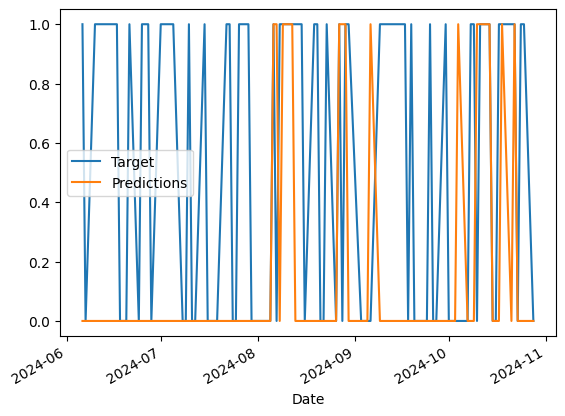

In [13]:
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
combined.plot()

In [14]:
# Develop a backtesting engine
start = 1000
step = 50
i = 1000

def backtest(data, model, predictors, start=1000, step=750):
    start_time = time.time()
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        model.fit(train[predictors], train["Target"])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0
        
        # predict_proba returns two columns array before using [:,1]
        # Column 1: probability of 0, price goes down
        # Column 2: probability of 1, price goes up
        
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        predictions.append(combined)
        
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    return predictions

In [15]:
# Improving accuracy
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [16]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", 
                                "weekly_trend", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

In [17]:
# One predictor
predictions = backtest(data, model, predictors, start=start, step=50)
predictions = pd.concat(predictions)
one_precision = precision_score(predictions["Target"], predictions["Predictions"])

# Multiple predictors
predictions = backtest(data, model, full_predictors, start=start, step=50)
predictions = pd.concat(predictions)
multiple_precision = precision_score(predictions["Target"], predictions["Predictions"])

print(f"One Predictor Precision Score = {one_precision}")
print(f"Multiple Predictor Precision Score = {multiple_precision}")

Execution time: 712.1733498573303 seconds
Execution time: 632.5860552787781 seconds
One Predictor Precision Score = 0.4991652754590985
Multiple Predictor Precision Score = 0.5982658959537572


In [18]:
predictions["Predictions"].value_counts()

Predictions
0.0    8388
1.0     346
Name: count, dtype: int64

In [19]:
#TODO
# How much you lost or gained on days you bought
# Tweak thresholds
# Ensure smaller step sizes